In [1]:
#tflearn
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

#numpy, plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
from numpy import *

# SKLEARN
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#  data
train = r'traindata'    #path of folder of images 
train_names = os.listdir(train)

In [5]:
img_size = 50   # image size 
lr = 1e-3   # learning rate 
MODEL_NAME = 'huangshan-{}-{}.model'.format(lr,'CNN')

In [6]:
# list the images in a folder 
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [7]:
def label_img(class_id):
    label = [0]*8
    label[class_id] = 1.0
    return label

In [8]:
def create_train_data():
    class_id = 0
    training_data = []
    for train_name in train_names:
        dir = os.path.join(train, train_name)
        class_path = imlist(dir)
        for path in class_path:
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size, img_size))
            img = img / 255.0
            training_data.append([np.array(img).astype('float32'), np.array(label_img(class_id))])
        class_id+=1
    training_data = shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [9]:
train_data = create_train_data()

In [10]:
#load train_data, test_data
train_data = np.load('train_data.npy')

# CNN model

In [10]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

# Building convolutional convnet
convnet = input_data(shape=[None, img_size, img_size, 1], data_preprocessing=img_prep,
                     data_augmentation=img_aug, name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 8, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
X = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1)
Y = np.array([i[1] for i in train_data])

In [13]:
# validation set is 20%
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=0.2, 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 69  | total loss: 1.12233 | time: 0.847s
| Adam | epoch: 010 | loss: 1.12233 - acc: 0.5652 -- iter: 384/400
Training Step: 70  | total loss: 1.09424 | time: 2.004s
| Adam | epoch: 010 | loss: 1.09424 - acc: 0.5793 | val_loss: 0.93468 - val_acc: 0.6700 -- iter: 400/400
--


# Show predicted data 

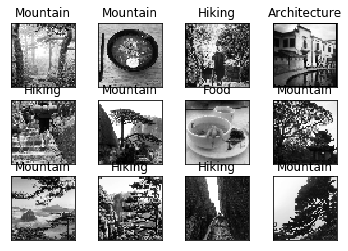

In [14]:
fig=plt.figure()

for num,data in enumerate(train_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size,img_size,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])
    
    if np.argmax(model_out[0]) == 0: str_label='Architecture'
    elif np.argmax(model_out[0]) == 1: str_label='Cloud'
    elif np.argmax(model_out[0]) == 2 : str_label = 'Food'
    elif np.argmax(model_out[0]) == 3 : str_label = 'Hiking'
    elif np.argmax(model_out[0]) == 4 : str_label = 'Mountain'    
    elif np.argmax(model_out[0]) == 5 : str_label = 'Other'
    elif np.argmax(model_out[0]) == 6 : str_label = 'People'    
    else: str_label = 'Pine'    
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()